# Util

Miscellaneous util code.

In [ ]:
#| default_exp util

In [ ]:
#| export
from genQC.imports import *
import gc, sys, traceback

## Memory utils

In [ ]:
#|export
class MemoryCleaner():
    """CLass with static methods to clean (gpu) memory."""
    
    @staticmethod
    def _clean_ipython_hist():
        # Code in this function mainly copied from IPython source
        if not 'get_ipython' in globals(): return
        ip = get_ipython()
        user_ns = ip.user_ns
        ip.displayhook.flush()
        pc = ip.displayhook.prompt_count + 1
        for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
        user_ns.update(dict(_i='',_ii='',_iii=''))
        hm = ip.history_manager
        hm.input_hist_parsed[:] = [''] * pc
        hm.input_hist_raw[:] = [''] * pc
        hm._i = hm._ii = hm._iii = hm._i00 =  ''

    @staticmethod
    def _clean_tb():
        if hasattr(sys, 'last_traceback'):
            traceback.clear_frames(sys.last_traceback)
            delattr(sys, 'last_traceback')
        if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
        if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
        
    @staticmethod
    def purge_mem():
        """Clear all. Purge all memory."""
        MemoryCleaner._clean_tb()
        MemoryCleaner._clean_ipython_hist()
        gc.collect()
        torch.cuda.empty_cache()    

## Python utils

In [ ]:
#| export
def virtual(f: callable) -> callable:
    '''Decorator to enfore subclass method implementations and raises error at method calls.'''
    @functools.wraps(f)
    def inner(self, *args, **kwargs): raise NotImplementedError(f"Virtual method {f.__name__} needs to be implemented by subclass {self.__class__.__name__}.")      
    return inner

In [ ]:
class A():
    def p1(self, x): print("A p1", x)
    
    @virtual
    def p2(self, x): pass
 
class B(A):
    def p3(self, x): print("B p2", x)
    
b = B()
b.p1(1)
try:
    b.p2(1)
except BaseException as e:
    print("Exception that would be raised: ", e)

A p1 1
Exception that would be raised:  Virtual method p2 needs to be implemented by subclass B.


## Torch utils

In [ ]:
#|export
class DataLoaders:
    """Combines train and valid `DataLoader`."""
    def __init__(self, *dls: list[DataLoader]): self.train, self.valid = dls[:2]

In [ ]:
#| export
def infer_torch_device(): 
    if torch.cuda.is_available():   
        torch.backends.cudnn.benchmark = True

        dev_cap = torch.cuda.get_device_capability()
        
        if dev_cap[0] >= 8: # AMPERE
            print(f"[INFO]: Cuda device has a capability of {dev_cap[0]}.{dev_cap[1]} (>= 8), allowing tf32 matmul.")
            torch.backends.cuda.matmul.allow_tf32 = True
        
        return torch.device("cuda")
    return torch.device("cpu")

In [ ]:
infer_torch_device()

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


device(type='cuda')

In [ ]:
#| export
def number_of_paramters(model: nn.Module): return sum([p.flatten().shape[0] for p in model.parameters()])

In [ ]:
#| export
def normalize_tensor(t: torch.Tensor):
    """[0,1] to [-1,1]"""
    return t * 2.0 - 1.0

def scale_tensor(t: torch.Tensor):
    """[-1,1] to [0,1]"""
    return (t / 2.0 + 0.5).clamp(0.0, 1.0)

## Plot utils

In [ ]:
#| export
def savePdf(filename): plt.savefig(filename + '.pdf', bbox_inches='tight')
def savePng(filename): plt.savefig(filename + '.png', bbox_inches='tight')
def saveSvg(filename): plt.savefig(filename + '.svg', bbox_inches='tight')

In [ ]:
#| export
def plot_image_grid(imgs: Union[list, np.array, torch.Tensor], labels: list=None, labels_fs="medium", 
                    figsize=(16, 4), cols=8, cmap="Greys", show_colorbar=False, **imshow_kwargs):  
    if type(imgs) is list: n = len(imgs)
    elif type(imgs) is np.ndarray: n = imgs.shape[0]
    elif type(imgs) is torch.Tensor: n = imgs.shape[0]
    else: raise NotImplementedError("err type:", type(imgs))

    if n == 0: return

    cols = min(n, cols)
    rows = math.ceil(n/cols)

    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False, constrained_layout=True)   
    for i, (r, c) in enumerate(itertools.product(range(rows), range(cols))):
        plt.sca(axs[r,c])
        plt.axis('off')
         
        if i >= n: continue

        if labels is not None: plt.title(labels[i], fontsize=labels_fs)
        p = plt.imshow(imgs[i], cmap=cmap, **imshow_kwargs) #cmap ignored for RGB   
        if show_colorbar: plt.colorbar(p)
        
    plt.show()

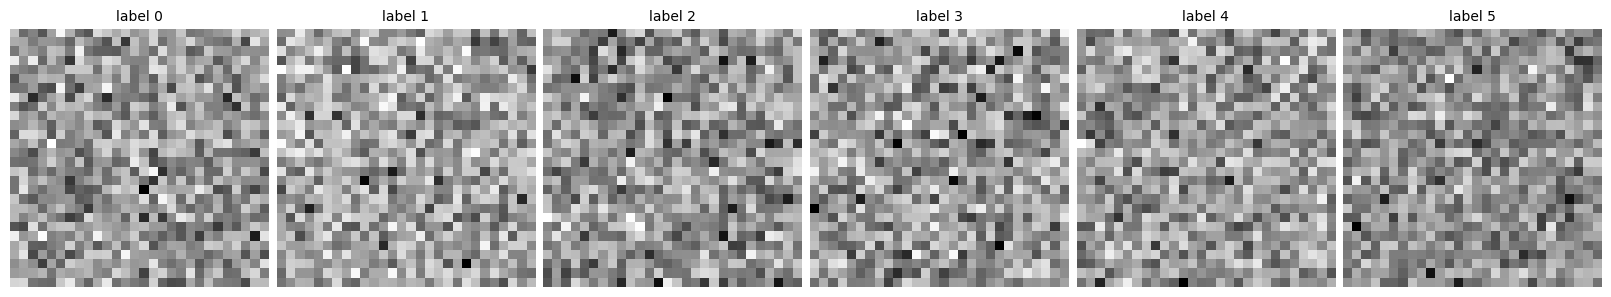

In [ ]:
n = 6
plot_image_grid(torch.randn((n,28,28,1)), [f"label {i}" for i in range(n)])

In [ ]:
#| export
def latents_to_pil(latents:torch.Tensor, channels=None):
    if channels is None:        
        channels = latents.shape[1] if len(latents.shape) > 3 else 1
            
    images = scale_tensor(latents)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    
    if channels == 1: images = images[:, :, :, 0]

    images = (images * 255).round().astype(np.uint8)
  
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images   

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()